In [25]:
import pandas as pd
import numpy as np
df = pd.read_csv("X_train_svd_150.csv")
X = df

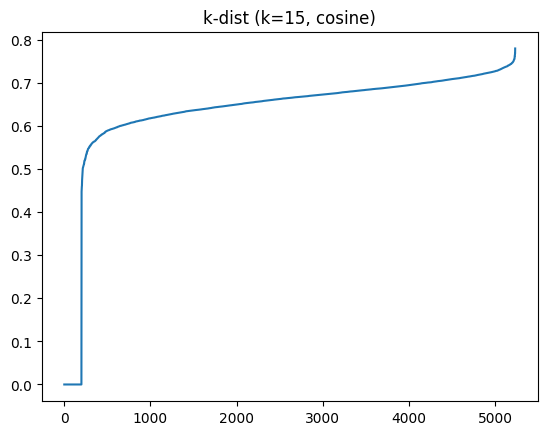

In [26]:
from sklearn.neighbors import NearestNeighbors
import numpy as np, matplotlib.pyplot as plt

m = 15                                  # prueba inicial
nbrs = NearestNeighbors(n_neighbors=m, metric='cosine').fit(X)
dists, _ = nbrs.kneighbors(X)
kd = np.sort(dists[:, m-1])
plt.plot(kd); plt.title(f'k-dist (k={m}, cosine)'); plt.show()

In [27]:
from collections import deque

def get_neighbors(X, i, eps):
    xi = X[i]
    xi_norm = np.sqrt(np.sum(xi**2))
    X_norms = np.sqrt(np.sum(X**2, axis=1))
    d = 1 - (X @ xi) / (X_norms * xi_norm + 1e-10)
    return np.where(d <= eps)[0]

def dbscan(X, eps=0.5, min_pts=5, metric="cosine"):
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    labels  = np.full(n, -1, dtype=int)
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    for i in range(n):
        if visited[i]:
            continue

        visited[i] = True
        neighbors = get_neighbors(X, i, eps)
        if len(neighbors) < min_pts:
            continue

        labels[i] = cluster_id
        Q = deque(neighbors)

        while Q:
            j = Q.popleft()

            if not visited[j]:
                visited[j] = True
                n_j = get_neighbors(X, j, eps)
                if len(n_j) >= min_pts:
                    Q.extend(n_j)

            if labels[j] == -1:
                labels[j] = cluster_id

        cluster_id += 1
    core_mask = np.zeros(n, dtype=bool)
    for i in range(n):
        if len(get_neighbors(X, i, eps)) >= min_pts:
            core_mask[i] = True

    return labels,core_mask

In [28]:
for eps in  (0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6):
    labels,core_mask = dbscan(X, eps=eps, min_pts=15, metric='cosine')
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps} -> clusters={n_clusters}, ruido={n_noise}")

eps=0.5 -> clusters=3, ruido=4912
eps=0.51 -> clusters=5, ruido=4846
eps=0.52 -> clusters=4, ruido=4809
eps=0.53 -> clusters=4, ruido=4754
eps=0.54 -> clusters=4, ruido=4676
eps=0.55 -> clusters=5, ruido=4506
eps=0.56 -> clusters=7, ruido=4258
eps=0.57 -> clusters=3, ruido=4002
eps=0.58 -> clusters=2, ruido=3708
eps=0.59 -> clusters=1, ruido=3384
eps=0.6 -> clusters=2, ruido=2890


In [29]:
eps_optimo = 0.56
min_samples = 15

labels,core_mask = dbscan(X,eps=eps_optimo, min_pts=min_samples, metric='cosine')

df["cluster"] = labels
df.to_csv("peliculas_clustered_final.csv", index=False)

print(df["cluster"].value_counts())

cluster
-1    4258
 0     621
 1     242
 5      55
 2      21
 3      13
 4      12
 6      11
Name: count, dtype: int64


In [30]:
X_train = pd.read_csv("X_train_svd_150.csv").to_numpy()
df_train = pd.read_csv("peliculas_clustered_final.csv")  
labels_train = df_train["cluster"].to_numpy()

n_train = X_train.shape[0]
core_mask_train = np.zeros(n_train, dtype=bool)
for i in range(n_train):
    if len(get_neighbors(X_train, i, eps_optimo)) >= min_samples:
        core_mask_train[i] = True

X_test = pd.read_csv("X_test_svd_150.csv").to_numpy()

train_norms = np.sqrt((X_train**2).sum(axis=1)) + 1e-10

def dbscan_predict_test(X_train, labels_train, core_mask_train, X_test, eps):
    preds = np.full(X_test.shape[0], -1, dtype=int)

    for t in range(X_test.shape[0]):
        xt = X_test[t]
        xt_norm = np.sqrt((xt**2).sum()) + 1e-10

        # distancias coseno a todos los puntos de train
        dots = X_train @ xt
        d = 1.0 - (dots / (train_norms * xt_norm))

        # candidatos: core points dentro de eps
        cand = np.where((d <= eps) & core_mask_train)[0]
        if cand.size > 0:
            j = cand[np.argmin(d[cand])]            # el más cercano (mínima distancia)
            preds[t] = labels_train[j]              # hereda la etiqueta de ese core point
        else:
            preds[t] = -1                           # ruido si no hay core vecino

    return preds

test_labels = dbscan_predict_test(X_train, labels_train, core_mask_train, X_test, eps_optimo)
pd.DataFrame({"cluster": test_labels}).to_csv("test_clusters_dbscan.csv", index=False)
print("Predicciones de test (DBSCAN) guardadas en 'test_clusters_dbscan.csv'")

# Resumen
vals, cnts = np.unique(test_labels, return_counts=True)
dist = {int(k): int(v) for k, v in zip(vals, cnts)}
print("Distribución test DBSCAN:", dist)

Predicciones de test (DBSCAN) guardadas en 'test_clusters_dbscan.csv'
Distribución test DBSCAN: {-1: 1830, 0: 260, 1: 84, 2: 13, 3: 3, 4: 5, 5: 21, 6: 7}


In [31]:
from sklearn.preprocessing import normalize

# === Cargar ===
movies = pd.read_csv("X_trained_scaled_final_no_cat (2).csv")
clusters = pd.read_csv("peliculas_clustered_final.csv")

# === Alinear movies con clusters de manera segura ===
def build_movies_clusters(movies_df, clusters_df, col_movie_id="movieId", col_cluster="cluster"):
    m = movies_df.copy(); c = clusters_df.copy()
    if col_movie_id not in m.columns:
        raise ValueError(f"'{col_movie_id}' no está en movies.")
    m[col_movie_id] = pd.to_numeric(m[col_movie_id], errors="coerce").astype("Int64")

    same_len = (len(c) == len(m))
    has_mid  = (col_movie_id in c.columns)
    has_cl   = (col_cluster in c.columns)

    if same_len and has_cl and not has_mid:
        out = pd.concat(
            [m.reset_index(drop=True), c[[col_cluster]].reset_index(drop=True)],
            axis=1
        )
    elif has_mid and has_cl:
        # Caso: clusters trae ['movieId','cluster'] -> merge por movieId
        c[col_movie_id] = pd.to_numeric(c[col_movie_id], errors="coerce").astype("Int64")
        out = m.merge(c[[col_movie_id, col_cluster]], on=col_movie_id, how="left")
    elif same_len and set(c.columns) == {col_cluster}:
        # (compat) clusters solo tiene 'cluster' y misma longitud -> concatenar por índice
        out = pd.concat([m.reset_index(drop=True), c.reset_index(drop=True)], axis=1)
    else:
        raise ValueError(
            "No puedo alinear 'clusters' con 'movies'. "
            "Esperaba (mismo largo y columna 'cluster' sin movieId) o (merge por ['movieId','cluster'])."
        )

    if col_cluster not in out.columns:
        raise ValueError("Después de alinear, falta la columna 'cluster'.")

    return out

movies_clusters = build_movies_clusters(movies, clusters)

Xn = normalize(X.astype(float), norm="l2")
movie_ids = pd.to_numeric(movies_clusters["movieId"], errors="coerce").astype("Int64").to_numpy()
id_to_row = {int(mid): i for i, mid in enumerate(movie_ids)}

# === Motor de recomendaciones ===
def make_submission(
    movies_clusters: pd.DataFrame,
    query_ids: list[int] | np.ndarray,
    k: int = 10,
    *,
    col_movie_id: str = "movieId",
    col_cluster: str = "cluster",
    pad_width: int = 4,
    seed: int = 42,
    respaldo_global: bool = True,
    fallback_knn: int = 300   # cuántos vecinos considerar cuando label = -1
) -> pd.DataFrame:

    mc = movies_clusters.copy()
    mc[col_movie_id] = pd.to_numeric(mc[col_movie_id], errors="coerce").astype("Int64")

    # índices/precomputados
    mc_idx = mc.set_index(col_movie_id)
    cluster_to_ids = (
        mc[[col_movie_id, col_cluster]]
        .dropna()
        .groupby(col_cluster)[col_movie_id]
        .apply(lambda s: s.astype("Int64").values)
        .to_dict()
    )
    universo_ids = mc[col_movie_id].dropna().astype(int).values

    rng = np.random.default_rng(seed)

    def fmt_id(x): return str(int(x)).zfill(pad_width)

    def lista_para_q(qid: int, n: int) -> list[int]:
        if pd.notna(qid) and (qid in mc_idx.index):
            cl = mc_idx.loc[qid, col_cluster]

            # Caso 1: cluster válido
            if cl != -1:
                cand = cluster_to_ids.get(cl, np.array([], dtype=int))
                cand = cand[cand != qid]
                if len(cand) > 0:
                    m = min(n, len(cand))
                    idx = rng.choice(len(cand), size=m, replace=False)
                    return list(cand[idx])

            # Caso 2: cluster = -1 -> fallback KNN-coseno
            if int(qid) in id_to_row:
                i = id_to_row[int(qid)]
                sims = Xn @ Xn[i]
                order = np.argsort(-sims)
                neigh_rows = [r for r in order if r != i][:300]  # top-300 candidatos
                recs = [int(movie_ids[r]) for r in neigh_rows]
                return recs[:n]

        # Respaldo global si se habilitó
        if respaldo_global and len(universo_ids) > 0:
            universo = universo_ids[universo_ids != int(qid)] if pd.notna(qid) else universo_ids
            m = min(n, len(universo))
            sel = rng.choice(universo, size=m, replace=False)
            return list(sel)

        return []

    # construir filas
    rows = []
    for qid in query_ids:
        recs = lista_para_q(int(qid), k)
        if len(recs) < k:
            recs = recs + [np.nan] * (k - len(recs))
        for pos, rid in enumerate(recs, start=1):
            rows.append({
                "query_movie_id": int(qid),
                "recommended_movie_id": "" if pd.isna(rid) else fmt_id(rid),
                "position": pos,
            })

    return pd.DataFrame(rows, columns=["query_movie_id", "recommended_movie_id", "position"])

# === Ejemplo ===
submission_dbscan = make_submission(movies_clusters, query_ids=[619], k=10, pad_width=4, seed=123)
submission_dbscan.to_csv("submission_dbscan.csv", index=False)
print("✅ submission_dbscan.csv generado")
print(submission_dbscan)


✅ submission_dbscan.csv generado
   query_movie_id recommended_movie_id  position
0             619               125974         1
1             619               104913         2
2             619                 0484         3
3             619                 5710         4
4             619               134170         5
5             619                34520         6
6             619                32666         7
7             619                 2698         8
8             619                 1275         9
9             619                 0711        10


In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


df_clusters = pd.read_csv("peliculas_clustered_final.csv")
labels = df_clusters["cluster"].to_numpy()

mask = labels != -1
Xf = X[mask]
lf = labels[mask]
metrics = {}

if mask.sum() > 0 and np.unique(lf).size >= 2:
    # Internas
    metrics["Silhouette_cosine"]        = float(silhouette_score(Xf, lf, metric="cosine"))
    metrics["Davies_Bouldin_euclidean"] = float(davies_bouldin_score(Xf, lf))
    metrics["Calinski_Harabasz_eucl"]   = float(calinski_harabasz_score(Xf, lf))
else:
    print("⚠️ Tras quitar ruido hay < 2 clusters; métricas no definidas.")
    metrics["Silhouette_cosine"]        = np.nan
    metrics["Davies_Bouldin_euclidean"] = np.nan
    metrics["Calinski_Harabasz_eucl"]   = np.nan

print(
    f"Silhouette (cosine, sin ruido): {metrics['Silhouette_cosine']}\n"
    f"Davies-Bouldin (euclídea): {metrics['Davies_Bouldin_euclidean']}\n"
    f"Calinski-Harabasz (euclídea): {metrics['Calinski_Harabasz_eucl']}"
)

Silhouette (cosine, sin ruido): 0.10371099831897519
Davies-Bouldin (euclídea): 2.4431048363349985
Calinski-Harabasz (euclídea): 35.26699512018205


# Gráficas

### Visualización de los cluster usando PCA

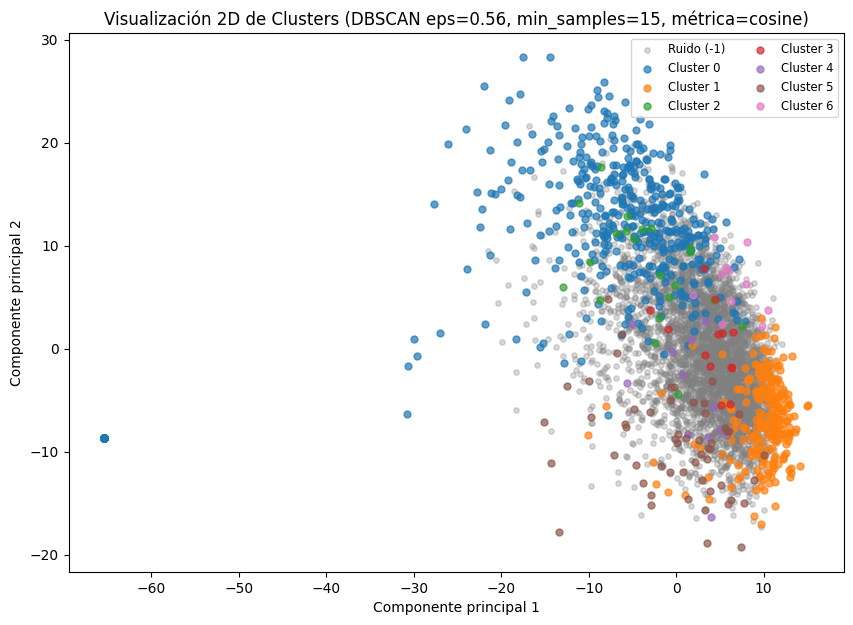

In [33]:
from sklearn.decomposition import PCA
labels = df["cluster"].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
unique_labels = np.unique(labels)
plt.figure(figsize=(10, 7))

for label in unique_labels:
    mask = labels == label
    if label == -1:
        # ruido (gris)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    color='gray', alpha=0.3, s=15, label='Ruido (-1)')
    else:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    alpha=0.7, s=25, label=f'Cluster {label}')

plt.title(f"Visualización 2D de Clusters (DBSCAN eps={eps_optimo}, min_samples={min_samples}, métrica=cosine)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()

### Sin ruido

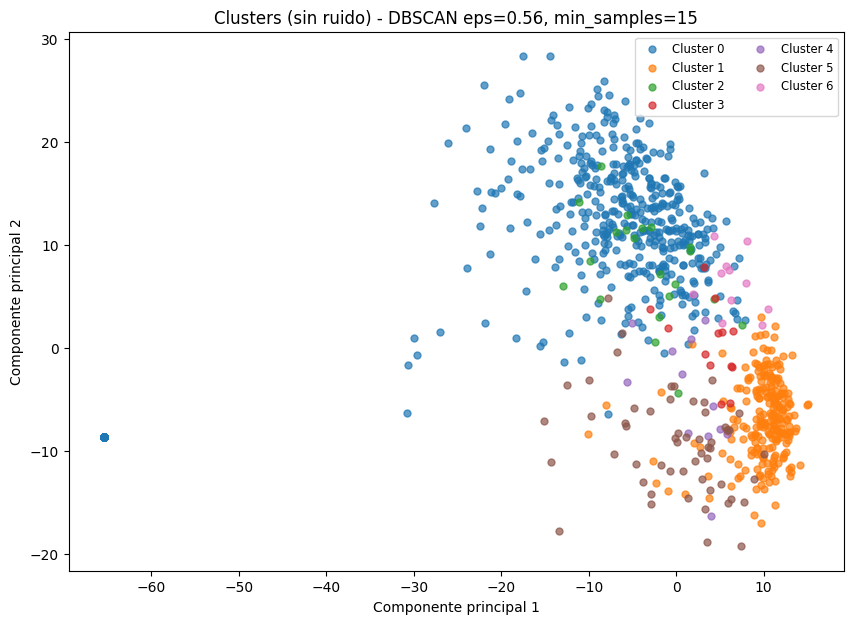

In [35]:
labels = df["cluster"].values
mask_no_ruido = labels != -1  # excluir el ruido
X_pca_filtered = X_pca[mask_no_ruido]
labels_filtered = labels[mask_no_ruido]

unique_labels = np.unique(labels_filtered)

#Graficar sin ruido
plt.figure(figsize=(10, 7))

for label in unique_labels:
    mask = labels_filtered == label
    plt.scatter(X_pca_filtered[mask, 0], X_pca_filtered[mask, 1],
                alpha=0.7, s=25, label=f'Cluster {label}')

plt.title(f"Clusters (sin ruido) - DBSCAN eps={eps_optimo}, min_samples={min_samples}")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()

### Distribución de tamaño de los Cluster

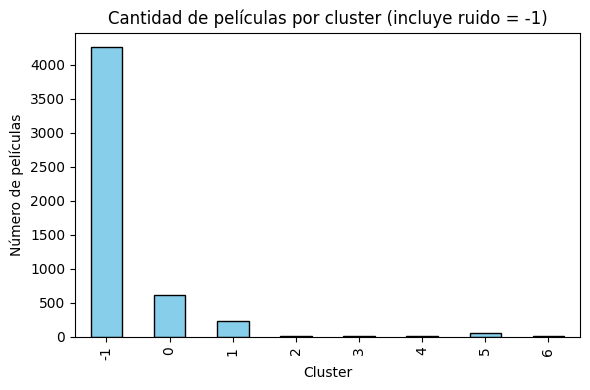

In [34]:
cnt = clusters["cluster"].value_counts().sort_index()

plt.figure(figsize=(6,4))
cnt.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Cantidad de películas por cluster (incluye ruido = -1)")
plt.xlabel("Cluster")
plt.ylabel("Número de películas")
plt.tight_layout()
plt.show()

### Gráfico del Silhouette Score por cluster

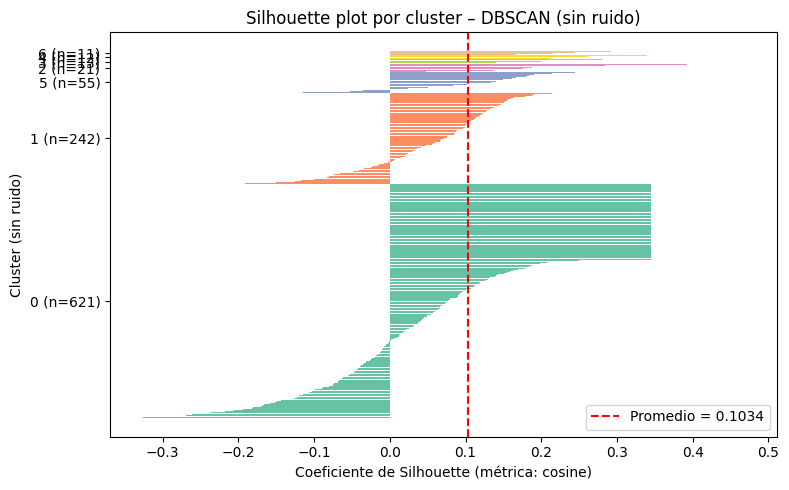

In [44]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Cargar X (SVD) y etiquetas DBSCAN ===
X = pd.read_csv("X_train_svd_150.csv").to_numpy()
labels = pd.read_csv("peliculas_clustered_final.csv")["cluster"].to_numpy()

# Filtrar ruido (-1)
mask = labels != -1
Xf = X[mask]
lf = labels[mask]

# Chequeo mínimo
uniq = np.unique(lf)
if Xf.shape[0] == 0 or uniq.size < 2:
    raise ValueError("Silhouette no definido: tras quitar ruido quedan < 2 clústeres o 0 muestras.")

# === Silhouette individual (cosine) ===
sil_vals = silhouette_samples(Xf, lf, metric="cosine")
mean_score = sil_vals.mean()

# (Opcional) ordenar clústeres por tamaño para un gráfico más limpio
clusters_order = [c for c, _ in sorted(((c, (lf==c).sum()) for c in uniq), key=lambda x: -x[1])]

# === Gráfico estilo “silhouette plot” ===
plt.figure(figsize=(8,5))
y_lower = 0
yticks = []
ylabels = []

for i, c in enumerate(clusters_order):
    c_vals = sil_vals[lf == c]
    c_vals.sort()
    size_c = c_vals.shape[0]
    y_upper = y_lower + size_c
    color = plt.cm.Set2(i % 8)
    plt.barh(range(y_lower, y_upper), c_vals, color=color, edgecolor="none")
    yticks.append((y_lower + y_upper) / 2)
    ylabels.append(f"{c} (n={size_c})")
    y_lower = y_upper

plt.axvline(mean_score, color="red", linestyle="--", label=f"Promedio = {mean_score:.4f}")
plt.yticks(yticks, ylabels)
plt.xlabel("Coeficiente de Silhouette (métrica: cosine)")
plt.ylabel("Cluster (sin ruido)")
plt.title("Silhouette plot por cluster – DBSCAN (sin ruido)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
